In [1]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from scipy.stats import mode

from alice.config import PROCESSING_INPUT_DIR, logger
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest
from imutils import perspective
from typing import List
from operator import attrgetter
from scipy.stats import zscore
import scipy.cluster.hierarchy as hcluster
from imutils.perspective import order_points

import cv2
import numpy as np
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
import csv
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
paths = [PROCESSING_INPUT_DIR / f'011250151_additional({i}).JPG' for i in range(1,5)]
# paths = [PROCESSING_INPUT_DIR / f'Tri434014_additional_{i}.JPG' for i in range(1,5)]

In [169]:
from random import randrange

def min_max(arr: np.array):
    return np.min(arr), np.max(arr)
    
def is_range_intersect(range1, range2):
    return  pd.Interval(*min_max(range1), closed='both').overlaps(pd.Interval(*min_max(range1), closed='both')) 

def random_colour():
    return (randrange(255), randrange(255), randrange(255))

def resize_image(image, max_width=2048, max_height=2048):

    # Get the original image dimensions
    height, width = image.shape[:2]
    ratio = []

    if height > max_height:
        ratio.append(max_height / height)

    if width > max_width:
        ratio.append(max_width / width)

    # If image needs to be resized, select smallest ratio (0.2 etc.,)
    # and resize both sides to that ratio
    if r := min(ratio):        
        new_width = round(r * width)
        new_height = round(r * height)
        image = cv2.resize(image, (new_width, new_height))

    return image

def calculate_angle(x1, y1, x2, y2, x3, y3):
    """
    Calculate angle between three points
    """
    vector1 = [x1 - x2, y1 - y2]
    vector2 = [x3 - x2, y3 - y2]
    
    dot_product = sum(i * j for i, j in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x**2 for x in vector1))
    magnitude2 = math.sqrt(sum(x**2 for x in vector2))
    
    angle_radians = math.acos(dot_product / (magnitude1 * magnitude2))
    return math.degrees(angle_radians)

In [4]:
# import craft functions
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

class Craft():

    def __init__(self, cuda=False):
        
        self.cuda = cuda
        # load models
        self.refine_net = load_refinenet_model(cuda=self.cuda)
        self.craft_net = load_craftnet_model(cuda=self.cuda)

    def detect(self, image):
        h, w = image.shape[:2]  
        # CRAFT internally scales to % 32 - so easier if we scale first
        # rather than trying to align image and heatmap
        h, w = self._calculate_32x_height_width(h, w)
        resized_image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        # Set long size to max dim, otherwise CRAFT will scale
        long_size = max([h, w])

        prediction = get_prediction(
            image=resized_image,
            craft_net=self.craft_net,
            refine_net=self.refine_net,
            text_threshold=0.7,
            link_threshold=0.4,
            low_text=0.4,
            cuda=self.cuda,
            long_size=long_size
        )

        heatmap = prediction["heatmaps"]['text_score_heatmap']
        # Heatmap will always be 2x smaller
        resized_heatmap = cv2.resize(heatmap, (resized_image.shape[1], resized_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        assert resized_heatmap.shape == resized_image.shape        
        prediction['image'] = resized_image
        prediction['resized_heatmap'] = resized_heatmap        
        return prediction

    @staticmethod
    def _scale_32x_dimension(d: int):
        # image height and width should be multiple of 32
        return round(d + (32 - (d % 32)))

    def _calculate_32x_height_width(self, h: int, w: int):
        shortest, longest = sorted([h, w])
        new_longest = self._scale_32x_dimension(longest)
        r = new_longest / longest
        new_shortest = self._scale_32x_dimension(r * shortest)
        return (new_longest, new_shortest) if h > w else (new_shortest, new_longest)   

craft = Craft(cuda=False)

/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [177]:
from abc import ABCMeta, abstractmethod

class Base():

    def __init__(self, image):
        self.image = image
        

    def visualise(self, image=None):
        image = self.image.copy() if image is None else image
        return self._visualise(image)

    @abstractmethod
    def _visualise(self, image):
        return None
    
    def log(self):
        image = self.visualise()
        plt.imshow(image), plt.show()  
        
        
class QuadrilateralROI(Base):
    def __init__(self, vertices, image, is_approx=False):
        super().__init__(image)
        
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)

        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    def get_closest_point(self, vertices):
        """
        Closest point is the bottom corner nearest the center point of the image
        """
        center = round(self.image.shape[1] / 2)
        vertices = np.array(vertices)
        bottom_corners = vertices[np.argpartition(vertices[:, 1], -2)[-2:]]
        x_offset_from_center = np.abs(bottom_corners[:, 0] - center)
        closest_point = bottom_corners[np.argmin(x_offset_from_center)]
        return tuple(closest_point)

    def get_corner_angles(self):
        angles = {}
        for e1, e2 in pairwise(list(self.edges.keys())):
            # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
            vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
            angles[vertice] = calculate_angle_between_lines(self.edges[e1], self.edges[e2])  
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def _visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 30)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 50)
        return image

    @property
    def x_length(self):
        return round(max([self.edges['a_b'].length, self.edges['c_d'].length]))

    @property
    def y_length(self):
        return round(max([self.edges['b_c'].length, self.edges['d_a'].length]))

    def is_landscape(self):
        return self.x_length > self.y_length

    def get_normalised_label(self, image, max_longest_edge, max_shortest_edge):
    
        if self.is_landscape():
            x = max_longest_edge
            y = max_shortest_edge
        else:
            x = max_shortest_edge
            y = max_longest_edge
            
        dest = np.float32([
            (0, x), #A
            (0, 0), #B
            (y, 0), #C
            (y, x) #D
        ])
        
        src = np.float32(list(self.vertices.values()))
        M = cv2.getPerspectiveTransform(src, dest)
    
        warped_image = cv2.warpPerspective(image, M,(y, x),flags=cv2.INTER_LINEAR) 

        # Longest edge should be the bottom
        h, w = warped_image.shape[:2]
        if h > w:
            warped_image = imutils.rotate_bound(warped_image, -90)

        return warped_image      
            

class LabelMask(Base):
    def __init__(self, data: np.array, image):
        super().__init__(image)
        self._data = data

    @property
    def height(self):
        return self._data.shape[0]

    @property
    def width(self):
        return self._data.shape[1]  

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self._data == True)[0]), max(np.where(self._data == True)[0])]) / 2 
        
    def get_contour(self, epsilon=5):
        contours, _ = cv2.findContours(self._data.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = np.vstack(contours)
        # Simplify contour - otherwise approx_best_fit_ngon takes many seconds
        # Requires low epsilon < 10 otherwise approx vertices are out
        if epsilon:
            contour = cv2.approxPolyDP(contour, epsilon, True)        
        return contour

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self._data, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def to_quadrilateral_roi(self):
        """
        Get quadrilateral ROI around mask
        """
        contour = self.get_contour()
        vertices = approx_best_fit_ngon(contour)
        quad_roi = QuadrilateralROI(vertices, self.image)

        print('HERE')
        self.log()
        
        # Move this outside - where we know the general shape from other labels
        if quad_roi.is_wellformed_label_shape():        
            return quad_roi

            
        
        
        print('Guesstimating corners')

        # TODO: Log
        # We want to get the two edges intersection at point A (closest corner)
        closest_edges = [quad_roi.edges[e] for e in ['a_b', 'd_a']]
        vertices = approx_quadrilateral_from_closest_edges(closest_edges, self)

        approx_quad_roi = QuadrilateralROI(vertices, self.image, is_approx=True)
        if approx_quad_roi.is_wellformed_label_shape(): 
            return approx_quad_roi  

    def _visualise(self, image):
        contour = self.get_contour()
        image = cv2.drawContours(image, contour, -1, (255, 255, 0), 20)
        vertices = approx_best_fit_ngon(contour)
        quad_roi = QuadrilateralROI(vertices, self.image)
        image = quad_roi.visualise(image)
        cv2.circle(image, quad_roi.closest_point, 5, (0,0,255), 50)   
        return image

def improve_contrast(image, discard=2):
    """

    :param image:
    :param discard:

    """
    image = skimage.img_as_float(image)
    out = np.zeros_like(image)

    for c, channel in enumerate(image.transpose(2, 0, 1)):
        low = np.percentile(channel.flatten(), discard)
        high = np.percentile(channel.flatten(), 100 - discard)
        out[..., c] = (np.clip(channel, low, high) - low) / (high - low)

    return out

class AngledView(Base):

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        image = cv2.imread(str(path))
        image = resize_image(image)
        super().__init__(image)
        self.predictions = predict_masks(self.image)
        self.label_masks = self.label_masks_from_predictions()
        # self.rois = self.label_masks_to_rois()

    def label_masks_from_predictions(self):
        predicted_masks = self._get_predicted_masks()
        label_masks = [LabelMask(m, self.image) for m in predicted_masks]
        # Sort by mask y midpoint
        label_masks.sort(key = attrgetter('y_midpoint'))
        return [label_masks[-1]]

    def _get_predicted_masks(self):
        predicted_masks = self.predictions.get('instances').to("cpu").pred_masks.numpy()
        predicted_masks = self.filter_small_masks(predicted_masks)
        # predicted_masks = self.remove_overlaps(predicted_masks)       
        return predicted_masks

    def label_masks_to_rois(self):
        return [m.to_quadrilateral_roi() for m in self.label_masks]
        
    def filter_small_masks(self, label_masks: np.array):
        return [m for m in label_masks if np.count_nonzero(m) > self.min_mask_size]

    # def remove_overlaps(self, label_masks: np.array):
    #     n_ = np.shape(label_masks)[0]
    
    #     overlaps = []
    #     for i in range(n_):
    #         msk1 = label_masks[i]
    #         N1 = len(np.where(msk1 == True)[0])
    #         for j in range(i + 1, n_):
    #             msk2 = label_masks[j]
    #             N2 = len(np.where(msk2 == True)[0])
    #             N_overlap = len(np.where((msk1 == True) & (msk2 == True))[0])
    #             print(N_overlap)
    #             R1 = np.round(N_overlap / N1, 4)
    #             R2 = np.round(N_overlap / N2, 4)
    #             if (N_overlap != 0) and ((R1 > 0.15) or (R2 > 0.15)):
    #                 overlaps.append([i, j, R1, R2, N_overlap])

    #     print(overlaps)
        
    #     overlaps_sorted = deepcopy(overlaps)
    #     overlaps_sorted = sorted(overlaps_sorted, key=lambda x: x[4], reverse=True)
    
    #     masks_new = deepcopy(label_masks)
    
    #     for o in overlaps_sorted:
    #         msk1 = masks_new[o[0]]
    #         msk2 = masks_new[o[1]]
    #         N_overlap = len(np.where((msk1 == True) & (msk2 == True))[0])
    #         R1 = np.round(N_overlap / len(np.where(msk1 == True)[0]), 4)
    #         R2 = np.round(N_overlap / len(np.where(msk2 == True)[0]), 4)
    
    #         msk_to_exclude_ = [o[0], o[1]][np.argmax([R1, R2])]
    #         msk_to_include_ = [o[0], o[1]][np.argmin([R1, R2])]
    
    #         new_mask = self.overlap_exclusion(msk_to_exclude_, msk_to_include_, masks_new)
    
    #         masks_new[msk_to_exclude_] = new_mask
    
    #     for i in range(n_):
    #         msk_orig = label_masks[i]
    #         msk_new = masks_new[i]
    #         n1 = len(np.where(msk_orig == True)[0])
    #         n2 = len(np.where(msk_new == True)[0])
    #         r = n2 / n1
    #         if r < 0.1:
    #             masks_new[i] = np.full(np.shape(masks_new[i]), False)

    #     return masks_new

    # @staticmethod
    # def overlap_exclusion(msk_to_exclude_, msk_to_include_, tst):
    #     msk_to_exclude = tst[msk_to_exclude_]
    #     msk_to_include = tst[msk_to_include_]
    #     msk_to_exclude_edit = deepcopy(msk_to_exclude)
    #     msk_to_exclude_edit[np.where(msk_to_include == True)] = False
    #     return msk_to_exclude_edit

    def __len__(self):
        return len(self.label_masks)

    def _visualise(self, image):
        v = Visualizer(image[:, :, ::-1],
           metadata=None, 
           scale=0.7, 
           instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(self.predictions["instances"].to("cpu"))
        image = v.get_image()[:, :, ::-1]    
        return image

class Specimen():
    def __init__(self, paths: List[Path]):
        views = [AngledView(p) for p in paths]
        # We only want to use a view if it has the same number of labels as other views
        # So calculate the modal of all labels, and then views with missing labels will be excluded
        num_labels_mode = mode([len(view) for view in views])        
        self.views = [view for view in views if len(view) == num_labels_mode.mode]
        if len(self.views) != len(views):
            logger.warning('Mismatched label count between views - %s views with %s labels will be used', len(self.views), num_labels_mode.mode)        

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

    def get_labels(self, label_index):

        # Normalise labels so they are all equal width and height - using the maximum width/height
        # of the largest label
        dimensions = np.array([
            sorted([view.rois[label_index].x_length, view.rois[label_index].y_length]) for view in self.views
        ])

        max_shortest_edge = np.max(dimensions[:,0])
        max_longest_edge = np.max(dimensions[:,1])    

        labels = []
        for view in self.views:
            roi = view.rois[label_index]
            labels.append(
                roi.get_normalised_label(view.image, max_longest_edge, max_shortest_edge)
            )

        # FIXME: loop through and 
        # First two labels will be opposite way up to last two - rotate the last two 180 degrees
        # FIXME: This doesn't check the orientation - but this should work either way
        # labels = labels[:2] + [imutils.rotate_bound(label, 180) for label in labels[2:]]
        return labels
      

# specimen = Specimen(paths)

view = AngledView(paths[1])

masks = view._get_predicted_masks()

# img = view.visualise()
# plt.imshow(img), plt.show()

# for roi in view.rois:
#     img = roi.visualise()
#     plt.imshow(img), plt.show()

#     closest_edges = [roi.edges[e] for e in ['a_b', 'd_a']]
    

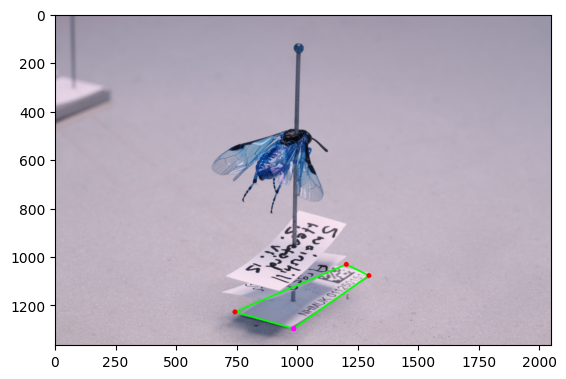

{'a': 128.84652271696612, 'b': 39.03734212280231, 'c': 130.5586906527578, 'd': 61.557444507473804}
False
True


In [183]:
INVALID_LABEL_SHAPE = -1

class LabelMask(Base):
    def __init__(self, mask: np.array, image):
        self.height, self.width = image.shape[:2]
        super().__init__(image)
        self.mask = mask.astype(np.uint8)

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self.mask == True)[0]), max(np.where(self.mask == True)[0])]) / 2 

    @property
    def contour(self):
        contours, _ = cv2.findContours(self.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # If we have multiple contours, only use the largest one
        sorted_countors = sorted(contours, key=cv2.contourArea, reverse=True)
        return sorted_countors[0]
        
    def get_polygon(self, epsilon=None):
        """
        Get polygon around the mask

        Note: otherwise approx_best_fit_ngon takes many seconds so requires 
        low epsilon < 10 otherwise approx vertices are out 
        epsilon=5 works well
        """
        if not epsilon:
            epsilon = 0.02 * cv2.arcLength(self.contour, True)
            
        return cv2.approxPolyDP(self.contour, epsilon, True)

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self.mask, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def _visualise(self, image):
        contour = self.contour
        image = cv2.drawContours(image, contour, -1, (255, 255, 0), 20)
        cv2.drawContours(image, [self.get_polygon()], -1, (0, 255, 0), 2)  # Draw in green        
        return image

    def subtract_mask(self, subtraction_mask):
        """
        Subtract mask from mask
        """
        self.mask = cv2.bitwise_and(self.mask, cv2.bitwise_not(subtraction_mask))        
        

label_masks = [LabelMask(mask, view.image) for mask in masks]
image = view.image.copy()
height, width = image.shape[:2]

# There are all on angledview
def get_higher_labels_mask(label_index):
    # Get masks higher up the label stack (lower masks have index 0)
    higher_masks = label_masks[label_index+1:]
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    for mask in higher_masks:
        cv2.fillPoly(combined_mask, [mask.get_polygon()], 255)

    return combined_mask

def remove_obscured_masks():
    """
    Some detected areas are actually parts of masks higher in the stack
    So filter out obscured areas
    """
    for label_index, mask in enumerate(label_masks):
        higher_labels_mask = get_higher_labels_mask(label_index)
        mask.subtract_mask(higher_labels_mask)

class Quadrilateral(Base):
    def __init__(self, mask):
        super().__init__(mask.image)
        contour = mask.get_polygon(epsilon=5)
        vertices = approx_best_fit_ngon(contour)
        
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)

        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    def get_closest_point(self, vertices):
        """
        Closest point is the bottom corner nearest the center point of the image
        """
        center = round(self.image.shape[1] / 2)
        vertices = np.array(vertices)
        bottom_corners = vertices[np.argpartition(vertices[:, 1], -2)[-2:]]
        x_offset_from_center = np.abs(bottom_corners[:, 0] - center)
        closest_point = bottom_corners[np.argmin(x_offset_from_center)]
        return tuple(closest_point)

    def get_corner_angles(self):
        angles = {}
        maxv = len(self.vertices) - 1
        for i, vertice in enumerate(self.vertices.keys()):    
            next_vertice = vertice_labels[i+1 if i < maxv else 0]
            prev_vertice = vertice_labels[i-1 if i > 0 else maxv]
            vertices = np.array([
                self.vertices[prev_vertice],
                self.vertices[vertice],
                self.vertices[next_vertice]
            ])
            angle = calculate_angle(*vertices.ravel())
            angles[vertice] = angle        
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def nearest_corner_is_good(self):
        """
        See if the nearest corner has acceptable angle range
        """
        lower_bound = 100
        upper_bound = 130
        return lower_bound <= self.angles['a'] <= upper_bound

    @property
    def x_length(self):
        return round(max([self.edges['a_b'].length, self.edges['c_d'].length]))

    @property
    def y_length(self):
        return round(max([self.edges['b_c'].length, self.edges['d_a'].length]))

    def is_landscape(self):
        return self.x_length > self.y_length

    def _visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 5)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 10)

        pt = np.array(self.closest_point).astype(np.int32)
        cv2.circle(image, pt, 5, (255,0,255), 12)            
        return image  



# for label_mask in label_masks:

view = AngledView(paths[0])
masks = view._get_predicted_masks()

label_masks = [LabelMask(mask, view.image) for mask in masks]
image = view.image.copy()
height, width = image.shape[:2]

remove_obscured_masks()

label_mask = label_masks[0]
quad = Quadrilateral(label_mask)

img = quad.visualise()
plt.imshow(img), plt.show()

print(quad.angles)

print(quad.is_wellformed_label_shape())

print(quad.nearest_corner_is_good())


# img = label_mask.visualise()
# plt.imshow(img), plt.show()

# image = view.image.copy()
# mask = masks[0]
# mask1 = masks[1]


# contours, _ = cv2.findContours(mask1.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# # for contour in contours:
# contours_sorted_by_area = sorted(contours, key=cv2.contourArea, reverse=True)
# image = cv2.drawContours(image, contours_sorted_by_area[0], -1, (255, 255, 0), 20)

# largest_contour = contours_sorted_by_area[0]


# cv2.drawContours(image, [approx_polygon], -1, (0, 255, 0), 2)  # Draw in green




OrderedDict([('a_b', <LINESTRING (944 1065, 770 891)>), ('b_c', <LINESTRING (770 891, 922 857)>), ('c_d', <LINESTRING (922 857, 1285 1079)>), ('d_a', <LINESTRING (1285 1079, 944 1065)>)])


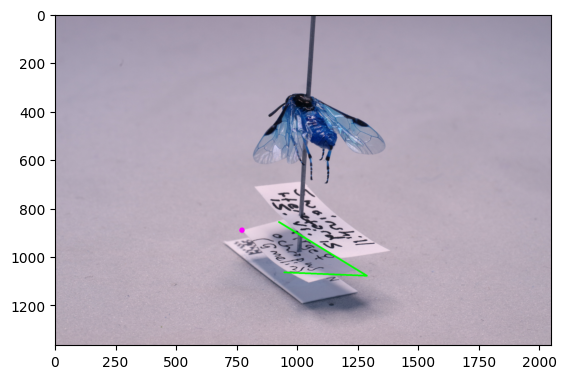

[[ 922  857]
 [ 944 1065]
 [1285 1079]]
(944, 1065)
(1285, 1079)
(922, 857)
137.3509990606348
a


NameError: name 'numpy' is not defined

In [162]:


image = quad.image.copy()

a = quad.vertices['b']
pt = np.array(a).astype(np.int32)
cv2.circle(image, pt, 5, (255,0,255), 12)   

a = quad.vertices['b']
pt = np.array(a).astype(np.int32)
cv2.circle(image, pt, 5, (255,0,255), 12) 

print(quad.edges)

e1 = quad.edges['d_a']
e2 = quad.edges['c_d']


pts1 = np.array(e1.coords).astype(np.int32)
x1,y1 = pts1
cv2.line(image, x1, y1, (0, 255, 0), 5)

pts2 = np.array(e2.coords).astype(np.int32)
x2, y2 = pts2
cv2.line(image, x2, y2, (0, 255, 0), 5)

plt.imshow(image), plt.show()

combined_array = np.concatenate((pts1, pts2))
unique_array = np.unique(combined_array, axis=0)
print(unique_array)
print(quad.vertices['a'])
print(quad.vertices['d'])
print(quad.vertices['c'])


unique_array = np.array([
    quad.vertices['d'],
    quad.vertices['a'],
    quad.vertices['b']
])

print(calculate_angle(*unique_array.ravel()))




# angles = {}
# for e1, e2 in pairwise(list(quad.edges.keys())):
#     # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
#     vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
    
#     edge1_points = np.array(quad.edges[e1].coords).astype(np.int32)
#     edge2_points = np.array(quad.edges[e2].coords).astype(np.int32)
    
#     points = np.concatenate((edge1_points, edge2_points))
#     three_points = np.unique(points, axis=0)
#     angles[vertice] = calculate_angle(*three_points.ravel()) 

# print(angles)        

# print(ab_points)
# print(da_points)
# combined_array = np.concatenate((ab_points, da_points))

# # Remove duplicates by getting the unique elements
# unique_array = np.unique(combined_array, axis=0)

# print(unique_array.ravel())

# # sorted_indices = np.argsort(unique_array[:, 1])

# # # Apply the sorted indices to the original array
# # unique_array = unique_array[sorted_indices]

    
# # # Calculate the angles at each corner
angle_A = calculate_angle(*unique_array.ravel())

# print(angle_A)

3






In [168]:
# vertice_labels = 


print(angles)

{'a': 137.3509990606348, 'b': 57.608606793366235, 'c': 135.94267793358011, 'd': 29.097716212418863}


In [51]:
x = [1,2,3,4]

x[1:]

[2, 3, 4]

In [6]:
# # for view in specimen.views:
# #     vis = view.visualise()
# #     plt.imshow(vis), plt.show()

# import skimage

label_index = 1

# # def get_label_rois(label_index):  
# #     return [view.rois[label_index] for view in specimen.views]

# # for label in specimen.get_labels(label_index):
# #     plt.imshow(label), plt.show()

# for view in specimen:
#     for roi in view.rois:
#         vis = roi.get_perspective_transformed(view.image)
#         plt.imshow(vis), plt.show()
#         break
        
    

labels = specimen.get_labels(label_index)

labels = labels[:2] + [imutils.rotate_bound(label, 180) for label in labels[2:]]

for view in specimen:
    for roi in view.rois:
        img = roi.visualise(view.image)
        plt.imshow(img), plt.show()

for i, label in enumerate(labels):
    plt.imshow(label), plt.show()

NameError: name 'specimen' is not defined

In [ ]:

# for view in specimen:
#     vis = view.image
#     plt.imshow(vis), plt.show()
    
#     # for roi in view.rois:
#     #     vis = roi.visualise(view.image)
#     #     plt.imshow(vis), plt.show()

# labels[0]


l = cv2.imread('label0.jpg')

In [ ]:
prediction1 = craft.detect(l)
prediction2 = craft.detect(labels[0])

import skimage
def improve_contrast(image, discard=2):
    """

    :param image:
    :param discard:

    """
    image = skimage.img_as_float(image)
    out = np.zeros_like(image)

    for c, channel in enumerate(image.transpose(2, 0, 1)):
        low = np.percentile(channel.flatten(), discard)
        high = np.percentile(channel.flatten(), 100 - discard)
        out[..., c] = (np.clip(channel, low, high) - low) / (high - low)

    return out

prediction3 = craft.detect(labels[2])

In [ ]:
for label in labels:
    plt.imshow(label), plt.show()

In [ ]:
# prediction1 = craft.detect(labels[2])
# plt.imshow(prediction1['resized_heatmap']), plt.show()
# plt.imshow(prediction1['image']), plt.show()

# plt.imshow(prediction2['resized_heatmap']), plt.show()
# plt.imshow(prediction2['image']), plt.show()

In [ ]:
# plt.imshow(prediction1['image']), plt.show()

In [ ]:

# def rectangle_get_vertices(rect):
#     top_left, bottom_right = rect    
#     top_right = np.array([bottom_right[0], top_left[1]])
#     bottom_left = np.array([top_left[0], bottom_right[1]])   
#     return np.array([top_left, top_right, bottom_right, bottom_left])

class TextLine():
    def __init__(self, rect, image, baseline_centroids):
        self.rect = rect
        x1, y1, x2, y2 = rect.ravel()
        self.orig_image = image[y1:y2, x1:x2]
        self.height, self.width = self.orig_image.shape[:2]
        # Baselines are calculate to the whole image - adjust
        baseline_centroids[:, 1] -= y1
        self.baseline_centroids = baseline_centroids
        self.image = self.deskew()
             
    def get_line_best_fit(self):
        # Fit a polynomial of degree 2 (quadratic)
        degree = 2      
        x, y = self.baseline_centroids.T
        coefficients = np.polyfit(x, y, degree) 
        return np.poly1d(coefficients)

    def deskew(self):
        poly = self.get_line_best_fit()
        x = np.linspace(0, self.width-1, self.width)        
        y_hat = poly(x)   
        # Offset is the predicted y values minus the maximum  
        y_offsets = max(y_hat) - y_hat
        deskewed = self.orig_image.copy()
        channels = deskewed.shape[2]
        # Roll down pixels by the offset from the line of best fit
        for i, y_offset in enumerate(y_offsets):
            y = round(y_offset)
            for c in range(channels):
                deskewed[:, i, c] = np.roll(deskewed[:, i, c], y)
            deskewed[:y, i, :] = 255
        return deskewed

    def visualise(self):
        image = self.orig_image.copy()
        poly = self.get_line_best_fit()
        xs = np.linspace(0, self.width -1, self.width)
        y_hat = poly(xs)
        for x, y in zip(xs.astype(int),y_hat.astype(int)):
            image[y, x] = [255, 0, 0]            
        
        return image


class Label():

    craft = Craft()

    # def __init__(image):
    #     prediction = self.craft.detect(image)
    #     self.text_lines = self.get_text_lines(prediction)
    
    def __init__(self, prediction):
        self.image = prediction['image']
        self.heatmap = prediction['resized_heatmap']        
        self.height, self.width = self.image.shape[:2]
        # self.lines = self._get_text_lines()
    
    def _get_text_lines(self):
        padding = 3
        rects = []
        clusters = self._get_clustered_rectangles()
        for cluster in clusters.values():
            ymin, ymax = minmax(cluster[:,:,1])
            # Adjust ymin / ymax by buffer
            ymin -= padding if ymin - padding > 0 else 0
            ymax += padding if ymax + padding < self.height else self.height
            # Line rectangle vertices
            line_rect = np.array([
                (0, ymin), 
                (self.width, ymax),
            ])
            # Calculate the baseline centroids of the heatmap (letter) rectangles
            baseline_centroids = np.array([
                (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in cluster
            ]) 
            rects.append(TextLine(line_rect, self.image, baseline_centroids))
            
        return rects

    @staticmethod
    def _filter_outliers(rects):
        """
        Filter any outlier rects by height (joined up letters)
        """
        threshold = 3
        rects = np.array(rects)
        rectangle_heights = np.abs(np.diff(rects[:,:,1]))
        z_scores = np.abs(zscore(rectangle_heights))
        return rects[np.where(z_scores < threshold)[0]]        

    def _get_heatmap_rectangles(self):
        """
        Draw rectangles around points of heatmap density (representing letters)   
        """
        # Define the threshold value - values above this will be hotspots to draw boxes around
        b, g, r = cv2.split(self.heatmap)
        # threshold = 200    
        
        height = self.heatmap.shape[0]
        # heatmap = np.array(cv2.cvtColor(self.heatmap, cv2.COLOR_BGR2GRAY))
    
        # # Create a binary mask
        # binary_mask = heatmap > threshold    


        b, g, r = cv2.split(self.heatmap)
        threshold = 120
        binary_mask = b < threshold  
        
        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
        rects = []        
    
        # Filter out smaller contours
        min_area = 4
        contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Remove any boxes along the top/bottom edges - overlapping from other rows
            if y == 0 or (y + h) >= height: continue            
            rects.append([(x, y), (x + w, y + h)])   
            
        return np.array(rects) 
    
    def _get_clustered_rectangles(self):
        heatmap_rects = self._get_heatmap_rectangles()
        baselines = np.array([max(y) for y in heatmap_rects[:,:, 1]])
        thresh = 30
        # cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), thresh, criterion="distance")
        cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), t=3, criterion="maxclust")
        print(cluster_labels)
        clusters = {}
        for label, rect in zip(cluster_labels, heatmap_rects):
            clusters.setdefault(label, []).append(rect)

        return {label: self._filter_outliers(cluster) for label, cluster in clusters.items()}        
        
    def visualise(self):

        image = self.image.copy()
        clusters = self._get_clustered_rectangles()

        for label, cluster in clusters.items():
            color = random_colour()
            for rect in cluster:
                pt1, pt2 = rect
                cv2.rectangle(image, pt1, pt2, color, -1)

        # for text_line in self._get_text_lines():
        #     color = random_colour()
        #     pt1, pt2 = text_line.rect
        #     cv2.rectangle(image, pt1, pt2, color, 1)                
        return image
        
        
label = Label(prediction1)

# for line in label.lines:
#     vis = line.visualise()
#     plt.imshow(vis, 'gray')
#     plt.show()
#     plt.imshow(line.image, 'gray')
#     plt.show()    
# # for line in label.text_lines:
# #     print(line)

image = label.visualise()
plt.imshow(image, 'gray')


In [ ]:
heatmap = prediction2['resized_heatmap']
b, g, r = cv2.split(heatmap)
plt.imshow(heatmap), plt.show()

# Convert BGR image to HSV
hsv_image = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)

# Define the blue hue range
lower_blue = np.array([120, 50, 50])
upper_blue = np.array([150, 255, 255])

# lower_blue = np.array([60, 50, 50])  # Lower hue value increased
# upper_blue = np.array([0, 255, 255])  # Upper hue value decreased

# Create a mask for blue elements

threshold = 40
binary_mask = b < threshold  

# blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
plt.imshow(binary_mask), plt.show()


In [ ]:
    # heatmap = np.array(cv2.cvtColor(b, cv2.COLOR_BGR2GRAY))

print(b)

# # Create a binary mask
# binary_mask = b > threshold    
# # Find contours in the binary mask
# contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
# rects = []        

# # Filter out smaller contours
# min_area = 4
# contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]

# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     # Remove any boxes along the top/bottom edges - overlapping from other rows
#     if y == 0 or (y + h) >= height: continue            
#     rects.append([(x, y), (x + w, y + h)])   
        
#     # return np.array(rects) 

In [ ]:

    
    
paths = [PROCESSING_INPUT_DIR / f'011250151_additional({i}).JPG' for i in range(1,5)]

path = paths[0]
image = cv2.imread(str(path))

x = resize_image(image)
plt.imshow(x), plt.show()

In [ ]:
v = np.array([(0, 10), (50, 15), (55, 400), (10, 390)])

In [ ]:
target_value = 396
